# BDI KLIP reduction pipeline tutorial

Create a BDI Object with a lot of knobs to turn.  This notebook replies on pcaskysub, badpixelfix, and bditools.findstars having been already performed on the dataset, with their associated outputs.

<IPython.core.display.Javascript object>


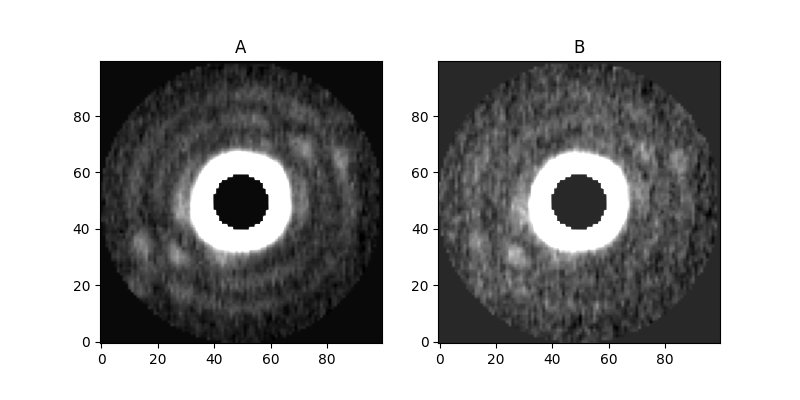

In [3]:
from cliotools.bdi import BDI
import pandas as pd

# Define the path to the folder of cleaned images
path = "BDI0933/"

# CleanList comes out of "-Fix Bad Pixels.ipynb", and is a
# list of all cleaned images with appendix "ssbp" (sky subtracted, bad pixel fixed),
# and has only closed loop images in the list.  It is the final list of only the
# images to be used in the reduction, and includes location of each star in each
# image.  PrepareCubes expects a Pandas Dataframe with column
# names=['filename', 'xca','yca', 'xcb', 'ycb']
k = pd.read_csv(path+'CleanList', 
                     delim_whitespace = False,  # Spaces separate items in the list
                     comment = '#',             # Ignore commented rows
                    )

# Create the BDI object and perform the actions of PrepareCubes function.  Args are saved as attributes of
# this object.  Aligned, masked, and normalized cubes are stored as BDIobject.acube and BDIobject.bcube
BDIobject = BDI(k, K_klip = 1,
                boxsize = 50,                  # Define postage stamp size
                path_prefix = '',              # Prepend path to images if necessary
                normalize = True,              # Toggle normalize (Default = True)
                inner_mask_core = True,        # Toggle masking the star's core (Default = True)
                inner_radius_format = 'pixels',# Mask radius defined in pixels (Default='pixels')
                inner_mask_radius = 10.,       # Mask all pixels interior to this radius
                outer_mask_annulus = True,     # Toggle masking outer annulus (Default = False)
                outer_radius_format = 'pixels',# Mask radius defined in pixels (Default='pixels')
                outer_mask_radius = 50.,       # Mask all pixels exterior to this radius
                mask_cval = 0,                 # Value to fill masked pixels
                verbose = False)               # If True, print status updates


# The first image in the cube of aligned, normalized, and masked images of Star A and Star B:
%matplotlib notebook
plt.figure(figsize = (8,4))
plt.subplot(121)
im = BDIobject.acube[0]
plt.imshow(im, origin='lower', cmap='gray',
               norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.title('A')
plt.subplot(122)
im = BDIobject.bcube[0]
plt.imshow(im, origin='lower', cmap='gray',
               norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.title('B')
plt.show()

K_klip =  1


<IPython.core.display.Javascript object>


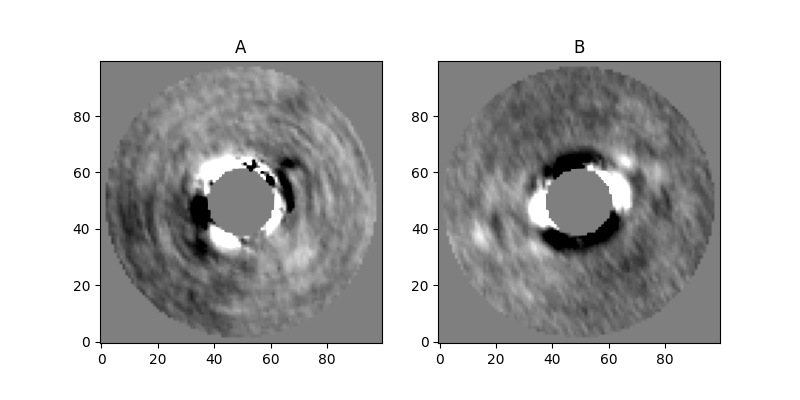

In [4]:
# Perform KLIP reduction using the function Reduce.  Reduced image outputs are stored as BDIobject.A_Reduced
# and BDIobject.B_Reduced.
BDIobject.Reduce(interp='bicubic',          # Keyword for OpenCV rotation interpolation method.  Default='bicubic'
                 rot_cval=np.nan,            # Value to fill extrapolated pixels after rotation. Default=np.nan
                 mask_interp_overlapped_pixels = True # Mask extra pixels that were interpolated with 
                )                                     # mask during rotate step


print('K_klip = ',BDIobject.K_klip)
%matplotlib notebook
plt.figure(figsize = (8,4))
plt.subplot(121)
im = BDIobject.A_Reduced
plt.imshow(im, origin='lower', cmap='gray',
               norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.title('A')
plt.subplot(122)
im = BDIobject.B_Reduced
plt.imshow(im, origin='lower', cmap='gray',
               norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.title('B')
plt.show()

In [ ]:
# Write reduced images to disk:
BDIobject.WriteToDisk(headercomment = 'Reduced today by me.', # Add comment to outfile header
                      outfilesuffix = 'TODAY',                # Suffix to append to outfile image name
                      write_directory = ''                    # Prepend path to desired write location
                     )

### The prep and reduce functions:
Some of the functions underlying the BDI object functionality and their parameters, spelled out in detail.

In [ ]:
# Import the two main functions:
from cliotools.bditools import SubtractCubes, PrepareCubes
# Import supporing functions:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the path to the folder of cleaned images
path = "BDI0933/"
# Identify the number of desired KLIP modes to use.
# Can be integer or array of integers.  If an array is given, SubtractCubes will
# return a cube of reduced images with KLIP modes in the Z axis.
K_klip = 1
# Define the size of the postage stamps around each star.
# The postage stamp will be 2*boxsize x 2*boxsize:
boxsize = 50

# CleanList comes out of "-Fix Bad Pixels.ipynb", and is a
# list of all cleaned images with appendix "ssbp" (sky subtracted, bad pixel fixed),
# and has only closed loop images in the list.  It is the final list of only the
# images to be used in the reduction, and includes location of each star in each
# image.  PrepareCubes expects a Pandas Dataframe with column
# names=['filename', 'xca','yca', 'xcb', 'ycb']

k = pd.read_csv(path+'CleanList', 
                     delim_whitespace = False,               # Spaces separate items in the list
                     comment = '#',                          # Ignore commented rows
                    )

# PrepareCubes opens each image, draws a postage stamp around each star, and adds it to an
# image cube, aligning the center of the star with the center of the postage stamp, at 
# 0.5*(length - 1) [ex: boxsize = 50 has center at 49.5,49.5].  It uses DAOStarFinder to
# find the center of the star in the postage stamp, and scipy.ndimage.shift to do the
# the interpolation (2 1D cubic splines).  
# Other preparation options that can be toggled on and off:
# Normalize: divide each postage stamp by the sum of all pixels in the image, to account
#   for flux differences between the two stars and over time.
# Masking: mask inner and outer areas of the star to create an annulus for reduction
#   by setting excluded pixels to a specified value (Default = zero).

astamp, bstamp = PrepareCubes(k, boxsize = boxsize,            # Define postage stamp size
                                path_prefix = '',              # Prepend path to images if necessary
                                normalize = True,              # Toggle normalize (Default = True)
                                inner_mask_core = True,        # Toggle masking the star's core (Default = True)
                                inner_radius_format = 'pixels',# Mask radius defined in pixels (Default='pixels')
                                inner_mask_radius = 10.,       # Mask all pixels interior to this radius
                                outer_mask_annulus = True,     # Toggle masking outer annulus (Default = False)
                                outer_radius_format = 'pixels',# Mask radius defined in pixels (Default='pixels')
                                outer_mask_radius = 50.,       # Mask all pixels exterior to this radius
                                cval = 0,                      # Value to fill masked pixels
                                verbose = False)               # If True, print status updates

# SubtractCubes performs the BDI KLIP math.  For the cube of Star A, it builds a PCA basis set
# using the cube of Star B, then steps through the stack of images on Star A, projecting each image
# onto the basis set to build a PSF model, and then subtracting the reconstructed model from the
# original image.  The subtracted image is derotated to North Up East Left using OpenCV2 rotation function.  
# When all images in the cube have been subtracted, it takes a sigma-clipped mean along the vertical 
# axis as the final reduced image.  Then repeats for Star B, using Star A as basis set.

a_final, b_final = SubtractCubes(astamp, bstamp,               # The outputs from PrepareCubes
                                    K_klip,                    # Number of KLIP modes
                                    k,                         # List of images in same order as stack
                                    write_to_disk = False,     # Write reduced images to fits file (Default=True)
                                    write_directory = '',      # Where to write image, if write=True
                                    outfilesuffix = '',        # Suffix for out file (klipcube_b_suffix.fits)
                                    headercomment = None,      # Add comment to header of out file
                                    verbose = False,           # If True, print status updates (Default=True)
                                    interp='bicubic',          # Keyword for OpenCV rotation interpolation method
                                    rot_cval=np.nan)           # Value to fill extrapolated pixels after rotation

%matplotlib notebook
plt.figure(figsize = (8,4))
plt.subplot(121)
im = a_final
plt.imshow(im, origin='lower', cmap='gray',
               norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.title('A')
plt.subplot(122)
im = b_final
plt.imshow(im, origin='lower', cmap='gray',
               norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.title('B')
plt.show()